In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
# from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
# Relevant libraries and functions
from __future__ import print_function
import random
import matplotlib.pyplot as plt
import scipy.ndimage
import numpy as np, h5py
import numpy.ma as npm
import os, time, sys
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Convolution2D, Input, SpatialDropout2D, UpSampling2D, MaxPooling2D, concatenate
from tensorflow.keras.layers import Activation, Conv2DTranspose
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Input, Conv2D, add, Conv3D, Reshape,Conv3DTranspose
from tensorflow.keras.callbacks import History, EarlyStopping, ModelCheckpoint, CSVLogger
from itertools import cycle
from sklearn import metrics
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils
from tensorflow.keras import backend
# from keras.backend.tensorflow_backend import set_session
from tensorflow.python.keras.backend import set_session
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D, Conv2DTranspose
from sklearn.utils import shuffle
import math 
from keras.utils import plot_model
import graphviz

C:\Users\Walshlab\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


#### Define discriminator

In [3]:
### Test 3D discriminator

def define_discriminator(image_shape):
    
    # weight initialization
    
    # source image input
    in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
    # target image input
    in_target_image = Input(shape=image_shape)  #Image we want to generate after training. 
    
    # concatenate images, channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    
    d = Conv3D(filters=128, kernel_size=(4,4,16), strides=(2,2,16), padding='same', activation=None)(merged)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.3)(d)
    
    d = Conv3D(filters=32, kernel_size=(2,2,8),strides=(2,2,4), padding='same', activation=None)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.3)(d)
    
#     d = Conv3D(filters=16, kernel_size=(2,2,4),strides=(1,1,2), padding='same', activation=None)(d)
#     d = BatchNormalization()(d)
#     d = LeakyReLU(alpha=0.2)(d)
#     d = Dropout(0.3)(d)
    
#     d = layers.GlobalAveragePooling3D()(d)
    
    d = Dense(units = 32, activation="relu")(d)
    d = Dense(units = 16, activation="relu")(d)
    d = Dense(units = 8, activation="relu")(d)
    

    
    
    patch_out = Dense(units=1, activation="sigmoid")(d)
#     patch_out = Dense(units=2)(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.
    model.summary(line_length = 120)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])

    return model

In [4]:
d_model = define_discriminator((32,32,256,1))
# plot_model(disc_model, to_file='disc_model.png', show_shapes=True)

Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_1 (InputLayer)                  [(None, 32, 32, 256, 1)]   0             []                                      
                                                                                                                        
 input_2 (InputLayer)                  [(None, 32, 32, 256, 1)]   0             []                                      
                                                                                                                        
 concatenate (Concatenate)             (None, 32, 32, 256, 2)     0             ['input_1[0][0]',                       
                                                                                 'input_2[0][0]']                       
                 

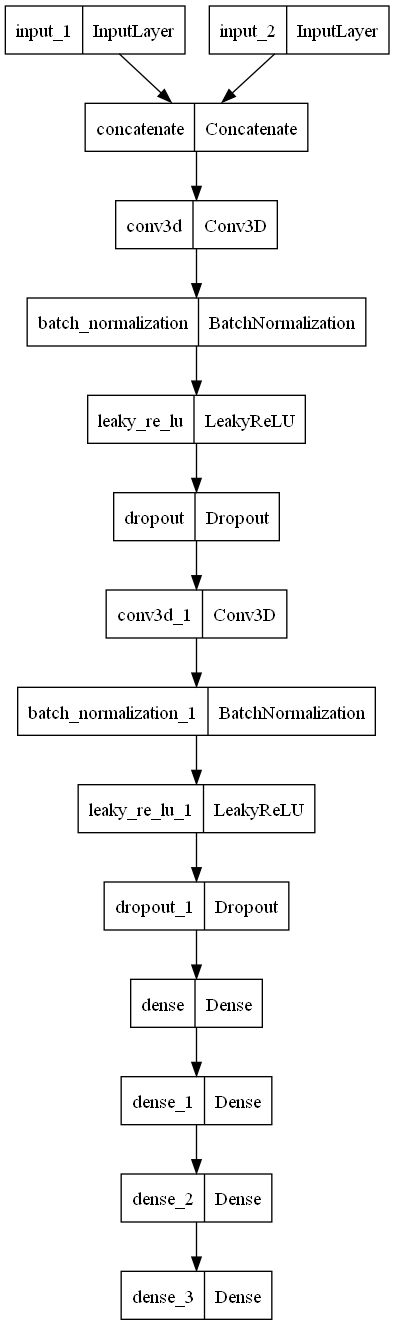

In [5]:
plot_model(d_model, to_file='D_Model_plot.png')

#### Define generator

In [10]:
##############################
#Now define the generator - in our case we will define a U-net
# define an encoder block to be used in generator
def define_encoder_block1(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv3D(n_filters, (2,2,16), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [11]:
##############################
#Now define the generator - in our case we will define a U-net
# define an encoder block to be used in generator
def define_encoder_block2(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv3D(n_filters, (2,2,4), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [12]:
def define_encoder_block(layer_in, n_filters, batchnorm=True, kernelSize = (2,2,4),strides=(2,2,2)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv3D(n_filters, kernelSize, strides, padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [13]:
# define a decoder block to be used in generator
def decoder_block1(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv3DTranspose(n_filters, (2,2,16), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

In [14]:
def decoder_block2(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv3DTranspose(n_filters, (2,2,4), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

In [15]:
#### Previous Version
# Input shape = 32 x 32 x 256
# Four encoder and decoder blocks
def define_generator(image_shape=(32,32,256,1)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    
    e1 = define_encoder_block2(in_image, 16, batchnorm=True)
    e2 = define_encoder_block2(e1, 32)
    e3 = define_encoder_block1(e2, 64)
    e4 = define_encoder_block1(e3, 128)
    
    b = Conv3D(64, (4,4,8), strides = (2,2,2), padding='same', kernel_initializer=init)(e4)
    b = Activation('relu')(b)
    
    
    d1 = decoder_block1(b, e4, 128)
    d2 = decoder_block1(d1, e3, 64, dropout=False)
    d3 = decoder_block2(d2, e2, 32, dropout=False)
    d4 = decoder_block2(d3, e1, 16, dropout=False)
    
    
    g = Conv3DTranspose(image_shape[2], (4,4,8), strides=(2,2,2), padding='same', kernel_initializer=init)(d4)
    g = Dense(64)(g)
    g = Dense(32)(g)
    g = Dense(16)(g)
    g = Dense(1)(g)
    
    
    out_image = Activation('tanh')(g)
    model = Model(in_image, out_image)
    model.summary(line_length = 120)
    return model

In [16]:
g_model = define_generator((32,32,256,1))

Model: "model_1"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_3 (InputLayer)                  [(None, 32, 32, 256, 1)]   0             []                                      
                                                                                                                        
 conv3d_2 (Conv3D)                     (None, 16, 16, 128, 16)    272           ['input_3[0][0]']                       
                                                                                                                        
 batch_normalization_2 (BatchNormaliza  (None, 16, 16, 128, 16)   64            ['conv3d_2[0][0]']                      
 tion)                                                                                                                  
               

                                                                                                                        
 conv3d_transpose_3 (Conv3DTranspose)  (None, 16, 16, 128, 16)    16400         ['activation_3[0][0]']                  
                                                                                                                        
 batch_normalization_9 (BatchNormaliza  (None, 16, 16, 128, 16)   64            ['conv3d_transpose_3[0][0]']            
 tion)                                                                                                                  
                                                                                                                        
 concatenate_4 (Concatenate)           (None, 16, 16, 128, 32)    0             ['batch_normalization_9[0][0]',         
                                                                                 'leaky_re_lu_2[0][0]']                 
                                

#### Define Gan

In [12]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape=(32,32,256,1)):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                #standalone descriminator will be trainable.
            
    # define the source image
    in_src = Input(shape=image_shape)
    # suppy the image as input to the generator 
    gen_out = g_model(in_src)
    # supply the input image and generated image as inputs to the discriminator
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and disc. output as outputs
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    
    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
    model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
    model.summary(line_length = 120)
    return model

In [13]:
gan_model = define_gan(g_model, d_model)

Model: "model_2"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_4 (InputLayer)                  [(None, 32, 32, 256, 1)]   0             []                                      
                                                                                                                        
 model_1 (Functional)                  (None, 32, 32, 256, 1)     4437537       ['input_4[0][0]']                       
                                                                                                                        
 model (Functional)                    (None, 8, 8, 2, 1)         206897        ['input_4[0][0]',                       
                                                                                 'model_1[0][0]']                       
               

#### Read the images

In [14]:
dataDirectory = 'E:\\Linghao Hu\\FLIM Enhan\\New Dataset\\Simulate_Dataset'  # Directory with trainging data
imageNumber = 100
imageStacks = os.listdir(dataDirectory)[:imageNumber]
stackNumber = int(len(imageStacks))

timePointNumber = 256 # Number of time-points
width = 28
height = 28



# Build the stack for each endpoint tpsfH, tpsfL, t1, t2, a1, a2

tpsfHImageStack = np.ndarray((stackNumber, int(timePointNumber), int(width), int(height), int(1)), dtype=np.float32)
tpsfLImageStack = np.ndarray((stackNumber, int(timePointNumber), int(width), int(height), int(1)), dtype=np.float32)

i = 0;

for d in imageStacks:
    # Save values to respective stack
    data = h5py.File(os.path.join(dataDirectory,d),'r')
    tpsfHImageStack[i,:,:,:,0] = data.get('hFLIM')
    tpsfLImageStack[i,:,:,:,0] = data.get('lFLIM')
    i = i + 1
    
# change the axis order of the stack 
tpsfHImageStack =  np.moveaxis(tpsfHImageStack, 1, -2)
tpsfLImageStack =  np.moveaxis(tpsfLImageStack, 1, -2)
 

In [15]:
tpsfHImageStack = np.squeeze(tpsfHImageStack)
tpsfLImageStack = np.squeeze(tpsfLImageStack)


def padTPSFImage(targetShape,inputImage):
    padding = [(0, targetShape[i] - inputImage.shape[i]) for i in range(len(targetShape))]
    paddedImage = np.pad(inputImage, padding, mode='constant')
    return paddedImage

padHImage = padTPSFImage((imageNumber,32,32,256),tpsfHImageStack)
padLImage = padTPSFImage((imageNumber,32,32,256),tpsfLImageStack)

#### Check the images

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def Montage_Image(imageList,n_col, image_size=28, margin=0):
    """
    Plot all the images listed in `img_names` in a gird with `n_col` columns.
    Images will be resized to `image_size`*`image_size`.
    This function assumes input images have the same shape.
    
    Args:
        img_names([string]): list of image paths
        n_col(int): number of images in one row
        image_size(int): the length of each image on the montage view
        margin(int): the horizonal and vertical gap between image image
        
    Returns:
        np.array: The montage view of all images listed in `img_names`
    """
    img_list = []
    for i in range(256):
        img_list.append(imageList[:,:,i])
    stack = np.hstack(img_list)

    # Compute number of rows
    n_row = math.ceil(256 / n_col)
    image = np.ones((n_row * image_size + (n_row - 1) * margin,
                     n_col * image_size + (n_col - 1) * margin)) * 255

    for i in range(int(stack.shape[1] / image_size)):
        r, c = i // n_col, i % n_col
        image[image_size * r + r * margin : image_size * (r + 1) + r * margin,
              image_size * c + c * margin : image_size * (c + 1) + c * margin
             ] = stack[:, image_size * i : image_size * (i + 1)]
        
    return image

In [17]:
def resize_image(image):
    image = image.reshape(32,32,256)
    montageImage = Montage_Image(image,32, image_size=32, margin= 0)
    return(montageImage)

In [18]:
montageHImage = resize_image(padHImage[0,:,:])
montageLImage = resize_image(padLImage[0,:,:])

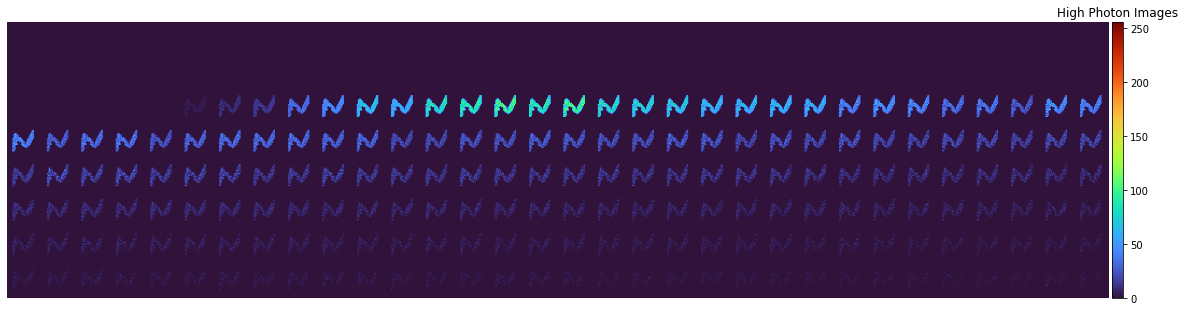

In [19]:
plt.figure(figsize=(20, round(montageHImage.shape[1] / montageHImage.shape[0] * 20)))
# plt.imshow(montageList, cmap='Blues',vmax =50)
plt.axis('off')
ax = plt.gca()
im = ax.imshow(montageHImage, cmap='turbo',vmax = 255)
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.title('High Photon Images')
plt.colorbar(im, cax=cax)
plt.show()

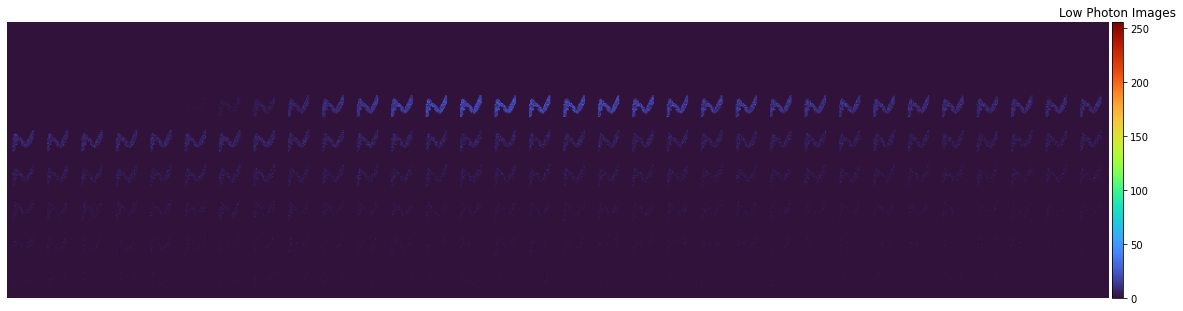

In [20]:
plt.figure(figsize=(20, round(montageLImage.shape[1] / montageLImage.shape[0] * 20)))
# plt.imshow(montageList, cmap='Blues',vmax =50)
plt.axis('off')
ax = plt.gca()
im = ax.imshow(montageLImage, cmap='turbo',vmax = 255)
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.title('Low Photon Images')
plt.colorbar(im, cax=cax)
plt.show()

#### Prepare for the images for training

In [21]:
# tpsfHImage = padHImage.reshape(1000,1024,256,1)
# tpsfLImage = padLImage.reshape(1000,1024,256,1)
# src_images = tpsfLImage
# tar_images = tpsfHImage
# padHImage = padHImage.reshape((imageNumber,32,32,256,1))
# padLImage = padLImage.reshape((imageNumber,32,32,256,1))

src_images = padLImage
tar_images = padHImage


data = [src_images, tar_images]

In [22]:
def preprocess_data(data):
    # load compressed arrays
    # unpack arrays
    X1, X2 = data[0], data[1]
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

dataset = preprocess_data(data)

In [23]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 2 , 1))
#     y = ones((n_samples, patch_shape))
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 2, 1))
#     y = zeros((len(X), patch_shape))
    return X, y

#### Train the model

In [24]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
# if (i+1) % (bat_per_epo * 10) == 0:
# summarize_performance(i, g_model, dataset)

In [26]:
train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=10) 

1/1 [==============================] - 0s 439ms/step
>1, d1[0.301] d2[0.409] g[103.491]
1/1 [==============================] - 0s 207ms/step
>2, d1[0.296] d2[0.411] g[56.596]
1/1 [==============================] - 0s 206ms/step
>3, d1[0.293] d2[0.411] g[25.481]
1/1 [==============================] - 0s 209ms/step
>4, d1[0.290] d2[0.412] g[11.543]
1/1 [==============================] - 0s 210ms/step
>5, d1[0.291] d2[0.408] g[6.555]
1/1 [==============================] - 0s 208ms/step
>6, d1[0.294] d2[0.402] g[4.576]
1/1 [==============================] - 0s 209ms/step
>7, d1[0.294] d2[0.404] g[3.743]
1/1 [==============================] - 0s 209ms/step
>8, d1[0.296] d2[0.400] g[3.162]
1/1 [==============================] - 0s 210ms/step
>9, d1[0.294] d2[0.401] g[3.034]
1/1 [==============================] - 0s 210ms/step
>10, d1[0.295] d2[0.395] g[2.847]
1/1 [==============================] - 0s 210ms/step
>11, d1[0.294] d2[0.398] g[2.628]
1/1 [==============================] - 0s 209ms

In [36]:
# g_model.save('FLIM_GAN_Test.h5')
g_model = tf.keras.models.load_model('FLIM_GAN_Test.h5')

In [37]:
x = 10
inputImage = padLImage[x,:,:]
inputImage = (inputImage-127.5)/127.5
inputImage = inputImage.reshape(1,32,32,256)
generatedImage = g_model.predict(inputImage)

1/1 [==============================] - 1s 542ms/step


In [38]:
# generatedImage = generatedImage * 127.5 + 127.5
generatedImage = generatedImage * 127.5 +127.5
generatedImage = generatedImage.astype(int)

In [39]:
generatedImage = generatedImage.reshape(32,32,256)
montageGImage = resize_image(generatedImage)

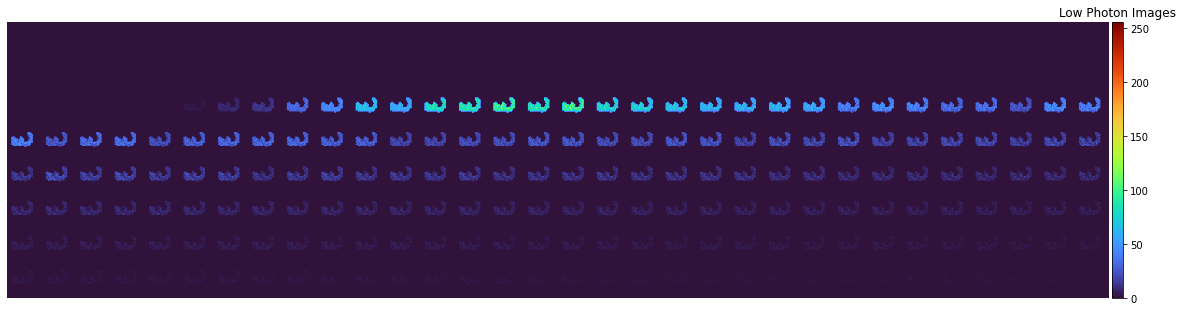

In [40]:
plt.figure(figsize=(20, round(montageGImage.shape[1] / montageGImage.shape[0] * 20)))
# plt.imshow(montageList, cmap='Blues',vmax =50)
plt.axis('off')
ax = plt.gca()
im = ax.imshow(montageGImage, cmap='turbo',vmax = 255, vmin = 0)
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.title('Low Photon Images')
plt.colorbar(im, cax=cax)
plt.show()

In [41]:
hImage = padHImage[x,:,:,:]
lImage = padLImage[x,:,:,:]
hImage = hImage.reshape(32,32,256)
lImage = lImage.reshape(32,32,256)



montageHImage = resize_image(hImage)
montageLImage = resize_image(lImage)

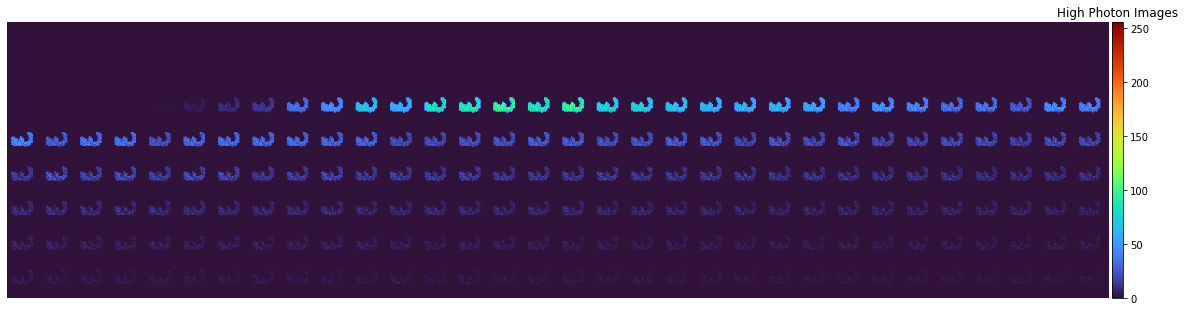

In [42]:
plt.figure(figsize=(20, round(montageHImage.shape[1] / montageHImage.shape[0] * 20)))
# plt.imshow(montageList, cmap='Blues',vmax =50)
plt.axis('off')
ax = plt.gca()
im = ax.imshow(montageHImage, cmap='turbo',vmax = 255)
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.title('High Photon Images')
plt.colorbar(im, cax=cax)
plt.show()

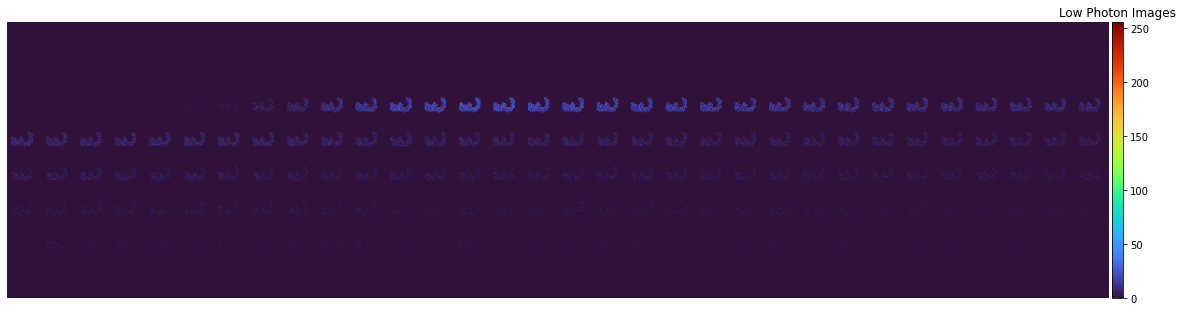

In [43]:
plt.figure(figsize=(20, round(montageLImage.shape[1] / montageLImage.shape[0] * 20)))
# plt.imshow(montageList, cmap='Blues',vmax =50)
plt.axis('off')
ax = plt.gca()
im = ax.imshow(montageLImage, cmap='turbo',vmax = 255)
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.title('Low Photon Images')
plt.colorbar(im, cax=cax)
plt.show()

In [44]:
predictDecay = np.sum(np.sum(generatedImage,axis = 0),axis = 0)
lDecay = np.sum(np.sum(lImage,axis = 0),axis = 0)
hDecay = np.sum(np.sum(hImage,axis = 0),axis = 0)

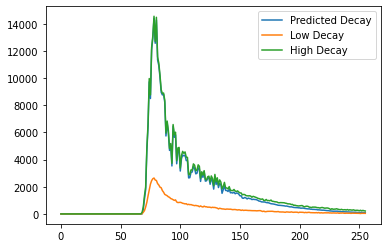

In [45]:
plt.plot(predictDecay,label = 'Predicted Decay')
plt.plot(lDecay, label = 'Low Decay')
plt.plot(hDecay,label = 'High Decay')
plt.legend()
plt.show()

In [34]:
# generate samples and save as a plot and save the model
#GAN models do not converge, we just want to find a good balance between
#the generator and the discriminator. Therefore, it makes sense to periodically
#save the generator model and check how good the generated image looks. 
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))